<a href="https://colab.research.google.com/github/Samakande/Project/blob/main/ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import csv

In [ ]:
classes = ["raccoon", "table", "chair", "stopsign", "keyboard", "face", "person", "bottle", "shoe", "object"]
myFile = open("_annotations.csv")
myFile_reader = csv.reader(myFile)
for row in myFile_reader:
  image_path = row[0]
  width = row[1]
  height = row[2]
  classs = row[3]
  xmin = row[4]
  ymin = row[5]
  xmax = row[6]
  ymax = row[7]

  img = plt.imread(image_path)
  bound_box = [xmin,ymin,xmax, ymax]
  index = classes.index(classs)
  class_channel = [1,0,0,0,0,0,0,0,0,0]  

  

  
arr_train = np.genfromtxt("_annotations.csv", delimiter=",")
data = pd.read_csv("_annotations.csv")


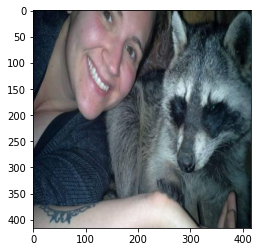

In [29]:
img = plt.imread("/content/raccoon-100_jpg.rf.YWIftfgUdZqJLTkvI9W2.jpg", )
plt.imshow(img)

In [ ]:
x = x_input = layers.Input(shape=(128, 128, 3))

x1 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
x2 = layers.MaxPool2D()(x1)
x3 = layers.BatchNormalization()(x2) # size: 64x64

x4 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x3)
x5 = layers.BatchNormalization()(x4)  # size: 64x64

x6 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x5)
x7 = layers.MaxPool2D()(x6)
x8 = layers.BatchNormalization()(x7)  # size: 32x32

x9 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x8)
x10 = layers.MaxPool2D()(x9)
x11 = layers.BatchNormalization()(x10)  # size: 16x16

x12 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x11)
x13 = layers.MaxPool2D()(x12)
x14 = layers.BatchNormalization()(x13) # size: 8x8x

# ---

x_prob = layers.Conv2D(1, kernel_size=3, padding='same', activation='sigmoid', name='x_prob')(x14)
x_boxes = layers.Conv2D(4, kernel_size=3, padding='same', name='x_boxes')(x14)
x_cls = layers.Conv2D(10, kernel_size=3, padding='same', activation='sigmoid', name='x_cls')(x14)

# ---

gate = tf.where(x_prob > 0.5, tf.ones_like(x_prob), tf.zeros_like(x_prob))
x_boxes = x_boxes * gate
x_cls = x_cls * gate

# ---

x15 = layers.Concatenate()([x_prob, x_boxes, x_cls])

model = tf.keras.models.Model(x_input, x15)
model.summary()

In [61]:
head = tf.keras.models.Model(x_input, x8)
tail = tf.keras.models.Model(x8, x15)
head.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_15 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_16 (Bat  (None, 64, 64, 32)       128

In [15]:
idx_p = [0]
idx_bb = [1, 2, 3, 4]
idx_cls = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

@tf.function
def loss_bb(y_true, y_pred):
    y_true = tf.gather(y_true, idx_bb, axis=-1)
    y_pred = tf.gather(y_pred, idx_bb, axis=-1)

    loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return tf.reduce_mean(loss[loss > 0.0])

@tf.function
def loss_p(y_true, y_pred):
    y_true = tf.gather(y_true, idx_p, axis=-1)
    y_pred = tf.gather(y_pred, idx_p, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_cls(y_true, y_pred):
    y_true = tf.gather(y_true, idx_cls, axis=-1)
    y_pred = tf.gather(y_pred, idx_cls, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_func(y_true, y_pred):
    return loss_bb(y_true, y_pred) + loss_p(y_true, y_pred) + loss_cls(y_true, y_pred)

opt = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(loss=loss_func, optimizer=opt)

In [35]:
def preview(numbers=None, threshold=0.9):
    X, y = make_data(size=1)
    X.shape
    y = head.predict(X)
    y= tail.predict(y)
    show_predict(X[0], y[0], threshold=threshold)
preview()

NameError: ignored

In [44]:
batch_size = 32
X_train, y_train = make_data(size=batch_size * 400)

In [18]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=3, shuffle=True)

Epoch 1/3
400/400 [==============================] - 446s 1s/step - loss: 196.1723
Epoch 2/3
400/400 [==============================] - 439s 1s/step - loss: 101.9882
Epoch 3/3
400/400 [==============================] - 443s 1s/step - loss: 86.1568


1/1 [==============================] - 0s 19ms/step


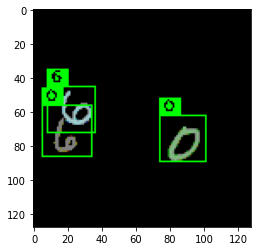

In [63]:
preview()